# AML Lab - Model training

## Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Echo Extraction

In [ ]:
import matplotlib.pyplot as plt
import os
from numpy import genfromtxt
from sklearn import preprocessing

(4, 2001)


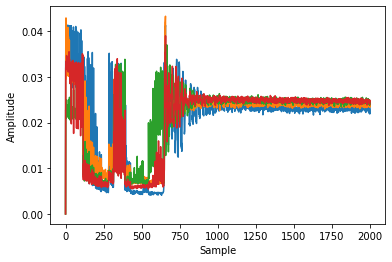

In [ ]:
path = "/content/drive/MyDrive/AML/ML/data/"
data_files = sorted(os.listdir(path))
file = data_files[0]
raw_data = genfromtxt(path + file, delimiter=',')

data = preprocessing.normalize(raw_data)
#data = raw_data
print(data.shape)

plt.plot(data[0])
plt.plot(data[1])
plt.plot(data[2])
plt.plot(data[3])
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

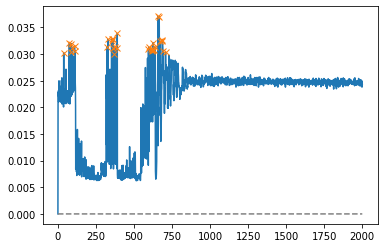

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
x = data[2]
peaks, _ = find_peaks(x, height=0.03)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [ ]:
# Identifying last peak from each mic
last_peaks = []
for i in range(4):
  x = data[i]
  peaks, _ = find_peaks(x, height=0.029)
  if peaks.size != 0:
    last_peaks.append(peaks[-1])
max(last_peaks)

789

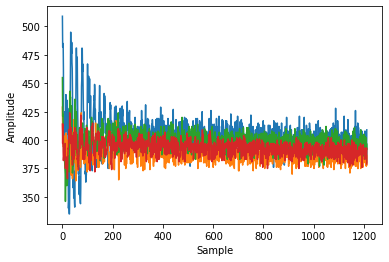

In [ ]:
# Plotting extracted echo
plt.plot(raw_data[0][max(last_peaks):])
plt.plot(raw_data[1][max(last_peaks):])
plt.plot(raw_data[2][max(last_peaks):])
plt.plot(raw_data[3][max(last_peaks):])
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# Full code for echo extraction
import matplotlib.pyplot as plt
import os
import re
from numpy import genfromtxt
from sklearn import preprocessing
from scipy.signal import find_peaks

path = "/content/drive/MyDrive/AML/ML/data/"
data_files = sorted(os.listdir(path))

# Number of samples per mic
samples = 256

new_data = []
labels_list = []
for j, file in enumerate(data_files):
  echoes = []
  last_peaks = []
  raw_data = genfromtxt(path + file, delimiter=',')
  # Normalizing data
  data = preprocessing.normalize(raw_data)

  # Identifying last peak from each mic
  for i in range(4):
    x = data[i]
    peaks, _ = find_peaks(x, height=0.029)
    if peaks.size != 0:
      last_peaks.append(peaks[-1])
  #print(last_peaks)
  far_peak = max(last_peaks)

  for i in range(4):
    echo = raw_data[0][far_peak:far_peak+samples]
    echoes.append(echo)
  echoes = np.array(echoes).transpose()
  new_data.append(echoes)

  # Labels
  labels = re.split(r'_|.csv', file)[0:4]
  labels = np.array([float(i) for i in labels])
  labels_list.append(labels)

new_data = np.array(new_data)
labels_list = np.array(labels_list)

print(new_data.shape)
print(labels_list.shape)

(101, 256, 4)
(101, 4)


In [ ]:
# Saving new data and labels
save_path = "/content/drive/MyDrive/AML/ML/"

np.save(save_path + "data.npy", new_data)
np.save(save_path + "labels.npy", labels_list)

In [ ]:
# Loading new data and labels
load_path = "/content/drive/MyDrive/AML/ML/"

dat = np.load(load_path + "data.npy")
lab = np.load(load_path + "labels.npy")

In [ ]:
dat

array([[[509., 509., 509., 509.],
        [482., 482., 482., 482.],
        [483., 483., 483., 483.],
        ...,
        [411., 411., 411., 411.],
        [396., 396., 396., 396.],
        [391., 391., 391., 391.]],

       [[555., 555., 555., 555.],
        [525., 525., 525., 525.],
        [487., 487., 487., 487.],
        ...,
        [399., 399., 399., 399.],
        [406., 406., 406., 406.],
        [417., 417., 417., 417.]],

       [[573., 573., 573., 573.],
        [591., 591., 591., 591.],
        [573., 573., 573., 573.],
        ...,
        [565., 565., 565., 565.],
        [566., 566., 566., 566.],
        [573., 573., 573., 573.]],

       ...,

       [[495., 495., 495., 495.],
        [465., 465., 465., 465.],
        [441., 441., 441., 441.],
        ...,
        [411., 411., 411., 411.],
        [420., 420., 420., 420.],
        [413., 413., 413., 413.]],

       [[590., 590., 590., 590.],
        [572., 572., 572., 572.],
        [539., 539., 539., 539.],
        .

In [ ]:
lab # Class, X, Y, Angle

(101, 4)

## Feature Extraction

In [ ]:
# Loading data
load_path = "/content/drive/MyDrive/AML/ML/"

dat = np.load(load_path + "data.npy")
lab = np.load(load_path + "labels.npy")[:,1:] # Take the class label out

## Training - Model 1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten
tf.random.set_seed(42)

In [ ]:
# Loading data
load_path = "/content/drive/MyDrive/AML/ML/"

dat = np.load(load_path + "data.npy")
lab = np.load(load_path + "labels.npy")[:,1:] # Take the class label out

a = dat[0]
a.shape

(256, 4)

In [ ]:
# Input shape: (number of samples, 4 mics, 256 wavepoints)
print(dat.shape)

# Output shape: (number of samples, labels [x,y,angle])
print(lab.shape)

(101, 256, 4)
(101, 3)


In [ ]:
# Separating training and test data
num_inputs = len(dat)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = dat[randomize]
outputs = lab[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

x_train, x_test, x_val = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_val = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

In [ ]:
x_train.shape[1:]

(256, 4)

In [ ]:
# Build a CNN
model = Sequential()

model.add(Conv1D(32, 3, activation='relu',input_shape=x_train.shape[1:]))
model.add(MaxPooling1D((3,)))
model.add(Flatten())
model.add(Dense(10,  activation='relu'))
model.add(Dense(3))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 254, 32)           416       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 84, 32)           0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 2688)              0         
                                                                 
 dense_13 (Dense)            (None, 10)                26890     
                                                                 
 dense_14 (Dense)            (None, 3)                 33        
                                                                 
Total params: 27,339
Trainable params: 27,339
Non-trainable params: 0
__________________________________________________

In [ ]:
#model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
#model.fit(x_train, y_train, epochs=50, batch_size=16,
#                    validation_data=(x_val, y_val))
    

#model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
#history = model.fit(x_train, y_train, epochs=600, batch_size=1, validation_data=(x_val, y_val))

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/100
4/4 [==============================] - 1s 69ms/step - loss: 6232.4478 - mae: 53.4904 - val_loss: 8490.9268 - val_mae: 48.4182
Epoch 2/100
4/4 [==============================] - 0s 23ms/step - loss: 6270.0127 - mae: 42.2766 - val_loss: 4052.0952 - val_mae: 40.3907
Epoch 3/100
4/4 [==============================] - 0s 23ms/step - loss: 4574.0669 - mae: 42.5243 - val_loss: 4007.7578 - val_mae: 39.9826
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 4151.6108 - mae: 38.6310 - val_loss: 4414.5903 - val_mae: 37.8879
Epoch 5/100
4/4 [==============================] - 0s 23ms/step - loss: 4124.7964 - mae: 36.2949 - val_loss: 4009.6150 - val_mae: 37.5434
Epoch 6/100
4/4 [==============================] - 0s 18ms/step - loss: 4262.0781 - mae: 38.7844 - val_loss: 3957.8530 - val_mae: 37.7590
Epoch 7/100
4/4 [==============================] - 0s 17ms/step - loss: 4055.7756 - mae: 36.2478 - val_loss: 4194.8438 - val_mae: 36.4173
Epoch 8/100
4/4 [=================

In [ ]:
predictions = model.predict(x_test)
print(predictions)
print(y_test)

1/1 [==============================] - 0s 24ms/step
[[ 1.66317308e+00  3.83850050e+00  1.56422363e+02]
 [ 1.84930134e+00  5.82546473e+00  1.92271637e+02]
 [ 3.27288556e+00  5.07688463e-01  2.19320709e+02]
 [ 1.42843068e+00  1.88715768e+00  1.17890839e+02]
 [ 5.04626274e-01  9.42214394e+00  1.49539047e+02]
 [ 1.35817719e+00  2.72147751e+00  1.23445473e+02]
 [ 2.76008081e+00  4.79785055e-02  1.80962280e+02]
 [ 2.16016150e+00  9.29167867e-02  1.43107849e+02]
 [ 1.42411137e+00  3.27018231e-01  9.88195877e+01]
 [ 1.99580729e+00 -5.01077712e-01  1.25433075e+02]
 [ 2.59114534e-01  7.37867165e+00  1.09208382e+02]
 [ 3.16557670e+00  2.87057734e+00  2.40918213e+02]
 [ 2.58405018e+00  3.93296766e+00  2.16498093e+02]
 [ 2.73763442e+00  7.22496331e-01  1.87651535e+02]
 [ 3.15568304e+00 -2.45888019e+00  1.76081604e+02]
 [ 1.04735541e+00  4.69037962e+00  1.27271500e+02]
 [ 6.32535219e-01  9.57487965e+00  1.59565399e+02]
 [ 4.12996626e+00 -6.54674649e-01  2.60172394e+02]
 [ 2.10933328e+00 -5.12173474e

In [ ]:
predictions = model.predict(x_test)
print("The total MSE is: {:.4f}".format(((predictions.flatten()-y_test.flatten())**2).mean()))
print("The x-coord MSE is: {:.4f}".format(((predictions[:,0]-y_test[:,0])**2).mean()))
print("The y-coord MSE is: {:.4f}".format(((predictions[:,1]-y_test[:,1])**2).mean()))
print("The orientation MSE is: {:.4f}".format(((predictions[:,2]-y_test[:,2])**2).mean()))

#diff = ((predictions - y_val) / y_val) * 100
#error_mean = np.mean(np.abs(diff))
#print("Predicting house prices - Estimation Error: {:.2f}%".format(error_mean))

1/1 [==============================] - 0s 24ms/step
The total MSE is: 5752.6417
The x-coord MSE is: 3.4985
The y-coord MSE is: 18.1226
The orientation MSE is: 17236.3041


### Plotting

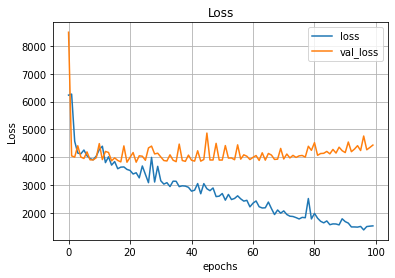

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epochs");
plt.ylabel("Loss");
plt.legend(["loss", "val_loss"])
plt.title("Loss")
plt.grid()

### Converting to C

In [ ]:
!pip install tinymlgen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinymlgen: filename=tinymlgen-0.2-py3-none-any.whl size=2242 sha256=755e43e01d0a4f71744a6cf289cfdd94b09ea698dad4fe89a8f60952388937a1
  Stored in directory: /root/.cache/pip/wheels/d4/bb/85/67c2a329ccd097a1902affa21433b569aed8e98621386fc6a9
  Created wheel for hexdump: filename=hexdump-3.3-py3-none-any.whl size=8913 sha256=55c17739fc34c74fb9c91f6f5be0689615bacb4da5be6a499dd0ab18e4258be3
  Stored in directory: /root/.cache/pip/wheels/91/40/39/0409f392f88124b0c07b4439bff985703dd0e737b5040febfb
Successfully built tinymlgen hexdump


In [ ]:
from tinymlgen import port

c_code = port(model, variable_name='echo_model', pretty_print=True)
print(c_code)


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char echo_model[] DATA_ALIGN_ATTRIBUTE = {
	0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 
	0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00, 
	0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 
	0x8c, 0x00, 0x00, 0x00, 0xe4, 0x00, 0x00, 0x00, 0xac, 0x72, 0x00, 0x00, 
	0xbc, 0x72, 0x00, 0x00, 0xe4, 0x7d, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 
	0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xde, 0x8b, 0xff, 0xff, 
	0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 
	0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f, 
	0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00,

### Playground

In [ ]:
import numpy as np
# Loading new data and labels
load_path = "/content/drive/MyDrive/AML/ML/"

dat = np.load(load_path + "data.npy")
lab = np.load(load_path + "labels.npy")

In [ ]:
dat[0].shape

(256, 4)

In [ ]:
dat[0].flatten()

array([509., 509., 509., ..., 391., 391., 391.])

In [ ]:
import numpy as np
a = np.array([[1,2,3,4],[1,2,3,4]])
a.flatten()

array([1, 2, 3, 4, 1, 2, 3, 4])

In [ ]:
import numpy as np
from tensorflow.keras import Sequential, layers
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# load and split dataset into train, validation, test
X, y = load_wine(return_X_y=True)
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

input_dim = X_train.shape[1:]
output_dim = y.shape[1]

print('input_dim', input_dim)
print('output_dim', output_dim)

input_dim (13,)
output_dim 3


In [ ]:
X_train.shape

(99, 13)

## Training - Model 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten
tf.random.set_seed(42)

In [ ]:
# Loading data
load_path = "/content/drive/MyDrive/AML/ML/"

dat = np.load(load_path + "data.npy")
lab = np.load(load_path + "labels.npy")[:,1:] # Take the class label out

a = dat[0]
a.shape

(256, 4)

In [ ]:
dat = dat.reshape((len(dat), 256, 4, 1))
dat.shape

(101, 256, 4, 1)

In [ ]:
# Input shape: (number of samples, 4 mics, 256 wavepoints)
print(dat.shape)

# Output shape: (number of samples, labels [x,y,angle])
print(lab.shape)

(101, 256, 4, 1)
(101, 3)


In [ ]:
# Separating training and test data
num_inputs = len(dat)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = dat[randomize]
outputs = lab[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

x_train, x_test, x_val = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_val = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

In [ ]:
x_train.shape[1:]

(256, 4, 1)

In [ ]:
# Build a CNN
model = Sequential()

model.add(Conv2D(16, 4, activation='relu',input_shape=(256,4,1)))
#model.add(MaxPooling2D(2,1))
model.add(Flatten())
model.add(Dense(10,  activation='relu'))
model.add(Dense(3))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 253, 1, 16)        272       
                                                                 
 flatten_24 (Flatten)        (None, 4048)              0         
                                                                 
 dense_48 (Dense)            (None, 10)                40490     
                                                                 
 dense_49 (Dense)            (None, 3)                 33        
                                                                 
Total params: 40,795
Trainable params: 40,795
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
#model.fit(x_train, y_train, epochs=50, batch_size=16,
#                    validation_data=(x_val, y_val))
    

#model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
#history = model.fit(x_train, y_train, epochs=600, batch_size=1, validation_data=(x_val, y_val))

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=8, validation_data=(x_val, y_val))

Epoch 1/100
8/8 [==============================] - 1s 31ms/step - loss: 23376.0801 - mae: 120.8168 - val_loss: 8645.3496 - val_mae: 83.5719
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 10115.5576 - mae: 76.5859 - val_loss: 9307.9023 - val_mae: 60.7378
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 8041.9155 - mae: 75.6671 - val_loss: 8039.0210 - val_mae: 77.2029
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 6204.7642 - mae: 58.4541 - val_loss: 5490.4121 - val_mae: 50.5306
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 4765.0938 - mae: 44.4237 - val_loss: 4779.2490 - val_mae: 36.1499
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 4227.7261 - mae: 36.8913 - val_loss: 5974.9346 - val_mae: 46.1160
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 4145.7124 - mae: 39.4795 - val_loss: 4728.2842 - val_mae: 39.0816
Epoch 8/100
8/8 [===============

In [ ]:
predictions = model.predict(x_test)
print(predictions)
print(y_test)

1/1 [==============================] - 0s 77ms/step
[[ 9.36446190e+00  1.96734867e+01  9.29541550e+01]
 [ 1.56249893e+00  4.25666237e+00  2.55663452e+02]
 [ 7.43627071e+00  3.22778368e+00  1.41171997e+02]
 [ 2.20044971e+00  9.35745299e-01  1.90589111e+02]
 [ 3.22290897e+00 -3.89514208e+00  1.16459160e+02]
 [ 4.90351057e+00  5.79358196e+00  1.62981400e+02]
 [ 2.85033727e+00  2.71780872e+00  1.46920120e+02]
 [-1.25946850e-01  3.30786765e-01  2.09878403e+02]
 [ 5.35193729e+00  9.53626919e+00  1.27786522e+02]
 [ 4.73835039e+00  6.95112705e+00  1.61328049e+02]
 [ 8.09876204e-01  3.27195787e+00  2.53060287e+02]
 [ 8.81162739e+00  1.23190851e+01  5.46573830e+01]
 [ 5.10423517e+00  2.26245737e+00  1.36422272e+02]
 [ 1.00541496e+01 -7.64609754e-01  2.56111221e+01]
 [ 6.50671768e+00  4.87063944e-01  9.66131897e+01]
 [ 1.89843035e+00  2.14559245e+00  2.78888367e+02]
 [ 4.50089216e+00  9.43274689e+00  1.08318504e+02]
 [ 4.05744171e+00  3.23509026e+00  3.70911560e+01]
 [ 6.64766455e+00  1.56256227e

In [ ]:
predictions = model.predict(x_test)
print("The total MSE is: {:.4f}".format(((predictions.flatten()-y_test.flatten())**2).mean()))
print("The x-coord MSE is: {:.4f}".format(((predictions[:,0]-y_test[:,0])**2).mean()))
print("The y-coord MSE is: {:.4f}".format(((predictions[:,1]-y_test[:,1])**2).mean()))
print("The orientation MSE is: {:.4f}".format(((predictions[:,2]-y_test[:,2])**2).mean()))

#diff = ((predictions - y_val) / y_val) * 100
#error_mean = np.mean(np.abs(diff))
#print("Predicting house prices - Estimation Error: {:.2f}%".format(error_mean))

1/1 [==============================] - 0s 27ms/step
The total MSE is: 5436.6818
The x-coord MSE is: 14.0290
The y-coord MSE is: 39.0889
The orientation MSE is: 16256.9275


### Plotting

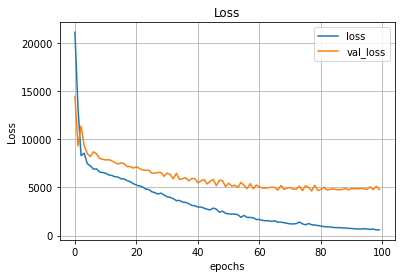

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epochs");
plt.ylabel("Loss");
plt.legend(["loss", "val_loss"])
plt.title("Loss")
plt.grid()

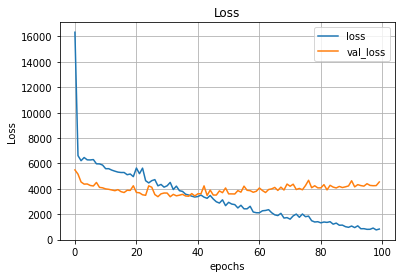

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epochs");
plt.ylabel("Loss");
plt.legend(["loss", "val_loss"])
plt.title("Loss")
plt.grid()

### Converting to C

In [ ]:
!pip install tinymlgen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tinymlgen import port

c_code = port(model, variable_name='echo_model', pretty_print=True, optimize=False)
print(c_code)


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char echo_model[] DATA_ALIGN_ATTRIBUTE = {
	0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 
	0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00, 
	0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 
	0x8c, 0x00, 0x00, 0x00, 0xe4, 0x00, 0x00, 0x00, 0x28, 0xa5, 0x00, 0x00, 
	0x38, 0xa5, 0x00, 0x00, 0x2c, 0xac, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 
	0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x02, 0x5a, 0xff, 0xff, 
	0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 
	0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f, 
	0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00,

### Playground

In [ ]:
import numpy as np
# Loading new data and labels
load_path = "/content/drive/MyDrive/AML/ML/"

dat = np.load(load_path + "data.npy")
lab = np.load(load_path + "labels.npy")

In [ ]:
dat[0].shape

(256, 4)

In [ ]:
dat[0].flatten()

array([509., 509., 509., ..., 391., 391., 391.])

In [ ]:
import numpy as np
a = np.array([[1,2,3,4],[1,2,3,4]])
a.flatten()

array([1, 2, 3, 4, 1, 2, 3, 4])

In [ ]:
import numpy as np
from tensorflow.keras import Sequential, layers
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# load and split dataset into train, validation, test
X, y = load_wine(return_X_y=True)
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

input_dim = X_train.shape[1:]
output_dim = y.shape[1]

print('input_dim', input_dim)
print('output_dim', output_dim)

input_dim (13,)
output_dim 3


In [ ]:
X_train.shape

(99, 13)